In [1]:
%matplotlib inline

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, gaussian_kde

from pyaldi.aldiparameter import ALDIParameter

from pyaldi.aldi import AldiSampler

### This is the true distribution we would like to sample from.

### It is a 2D distribution shaped as a banana.

``` _
//\
V  \
 \  \_
  \,'.`-.
   |\ `. `.       
   ( \  `. `-.                        _,.-:\
    \ \   `.  `-._             __..--' ,-';/
     \ `.   `-.   `-..___..---'   _.--' ,'/
      `. `.    `-._        __..--'    ,' /
        `. `-_     ``--..''       _.-' ,'
          `-_ `-.___        __,--'   ,'
             `-.__  `----"""    __.-'
                  `--..____..--'
```

$\pi \left( x \right) \propto \exp{ \left[ - \frac{1}{2\sigma_d^2} \left( \mu_d  - g \left( x \right) \right) ^2 \right] } \exp{ \left[ - \frac{1}{2\sigma_x^2} ||x||_2^2 \right]}$

The first part of the right hand side is identified as the likelihood and the second as the prior.

We define:

$g \left( x \right) = 10 x_1 + x_2 ^2 $

In [2]:
def g(x):
    return 10 * x[0] + x[1] ** 2

def prior(x, sig_x):
    return np.exp(- np.dot(x / sig_x, x / sig_x) / 2)

def likelihood(x, mu_d, sig_d):
    return np.exp(- (mu_d - g(x)) ** 2 / (2 * sig_d ** 2))

#### Plotting the true distribution on a grid

In [3]:
# Helper functions

def calc_posterior(x, mu_d, sig_x, sig_d):
    return prior(x, sig_x) * likelihood(x, mu_d, sig_d)

def calc_post_on_grid(x1s, x2s, mu_d, sig_x, sig_d):
    res = np.zeros((len(x1s), len(x2s)))
    for i, x1 in enumerate(x1s):
        for j, x2 in enumerate(x2s):
            res[i, j] = calc_posterior(np.array([x1, x2]), mu_d, sig_x, sig_d)
    return res

In [4]:
# the parameters of the distribution
mu_d = 4.
sig_x = 5.
sig_d = 4.

# defining a grid
lim = 15
x1 = np.arange(-lim, lim, 0.1)
x2 = np.arange(-lim, lim, 0.1)
grid = np.meshgrid(x1, x2)

y = calc_post_on_grid(x1, x2, mu_d, sig_x, sig_d)

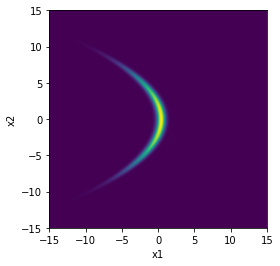

In [5]:
plt.imshow(y.T, extent=[-lim,lim,-lim,lim])
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

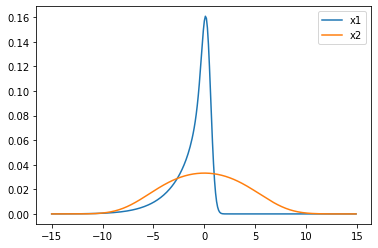

In [6]:
plt.plot(x1, y.mean(axis=-1), label='x1')
plt.plot(x2, y.mean(axis=0), label='x2')
plt.legend()
plt.show()

### Using ALDI to sample from the banana distribution

#### Defining the state and velocity objects

In [7]:
def grad_g(x):
    if x.shape[0] > 2:
        res = np.zeros(x.shape)
        res[0] = 10
        res[1] = 2 * x[1]
        return res
    else:
        return np.array([10, 2 * x[1]])

class StateParam(ALDIParameter):
    def __init__(self, init_val, mu_d, sig_x, sig_d):
        self.value = init_val
        
        self.mu_d = mu_d
        self.sig_x = sig_x
        self.sig_d = sig_d
    
    # the energy is the negative log likelihood
    def likelihood_energy(self, x):
        return (self.mu_d - g(x)) ** 2 / (2 * self.sig_d ** 2)

    def likelihood_energy_grad(self, x):
        return grad_g(x) * (g(x) - self.mu_d) / self.sig_d ** 2
    
    def prior_energy(self, x):
        return np.dot(x / sig_x, x / sig_x) / 2
    
    def get_prior_energy(self):
        return np.dot(self.value / sig_x, self.value / sig_x) / 2
    
    def get_g(self):
        return g(self.value)

    def prior_energy_grad(self, x):
        return x / self.sig_x ** 2
    
    def get_prior_energy_grad(self):
        return self.value / self.sig_x ** 2
        
    def get_energy_grad(self):
        return self.likelihood_energy_grad(self.value) + self.prior_energy_grad(self.value)

    def get_energy_for_value(self, x):
        return self.likelihood_energy(x) + self.prior_energy(x)

    def get_energy(self, *args):
        return self.get_energy_for_value(self.value)

#### Initializing the states matrix

In [60]:
num_particles = 6
D = 2
state_list = []
for n in range(num_particles):
    init_val_state = multivariate_normal.rvs(np.zeros(D),sig_x)
    state = StateParam(init_val_state, mu_d, sig_x, sig_d)
    state_list.append(state)

#### Initializing the sampler's parameters

In [61]:
step_size = 0.01
max_step_size = 0.5
num_samples = 20000

adaptive_step_size = True

In [62]:
aldi = AldiSampler(step_size, num_samples, num_particles, state_list, max_step_size, adaptive_step_size)

In [63]:
# This may take a moment or two depending on the number of samples
res = aldi.aldi()

In [64]:
 aldi.particles_path.shape

(20001, 2, 6)

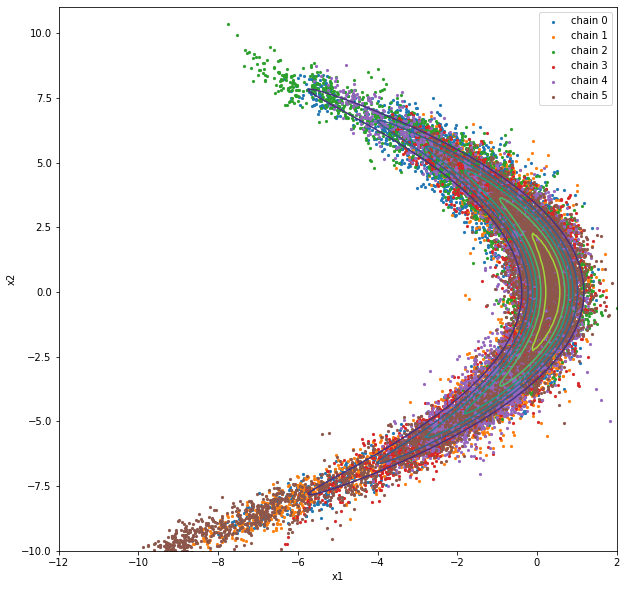

In [65]:
burnin = 15000
thinning = 1
samples = aldi.particles_path[burnin::thinning].T

plt.figure(figsize=(10,10))
plt.contour(x1, x2, y.T)
plt.xlim(-12,2)
plt.ylim(-10, 11)
plt.xlabel('x1')
plt.ylabel('x2')

for i, chain in enumerate(samples):
    
    x1_samps = chain[0]
    x2_samps = chain[1]    
    plt.scatter(x1_samps,x2_samps, marker='.', linewidths=0.2, label=f'chain {i}')
plt.legend()
plt.show()